In [ ]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
import random
from random import seed
import matplotlib.pyplot as plt
import numpy as np

#### Overview
Artificial Neural Networks are computational learning systems that uses a network of functions to understand and translate a data input of one form into a desired output, usually in another form. The concept of the artificial neural network was inspired by human biology and the way neurons of the human brain function together to understand inputs from human senses.

A simple neural network consists of Input Layer, Hidden Layer and Output Layer.
To train these the network, we will use Backpropagation algorithm.  Backpropagation is the cornerstone of modern neural networks. To understand the algorithm in details, here is a mathematical description in the Chapter 2 of *How the backpropagation algorithm works from Neural Networks and Deep Learning* (http://neuralnetworksanddeeplearning.com/chap2.html).

In this part, you are required to implement the following architecture and write training code of a neural network from scratch using the numpy library alone. 

Architecture Definition :

*   An Input Layer with the following 2-dimensions:
  *  0: Batch Size
  *  1: 784 = 28*28 pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units

There are five major steps to the implementation:

1. Define neural network: initialize_network()

2. Forward Propagation: pre_activation(), sigmoid_activation(), forward_propagation()

3. Backpropagation: backward_propagate_error()

4. Loss function and updation of weights (SGD): update_weights()

5. Training: train()


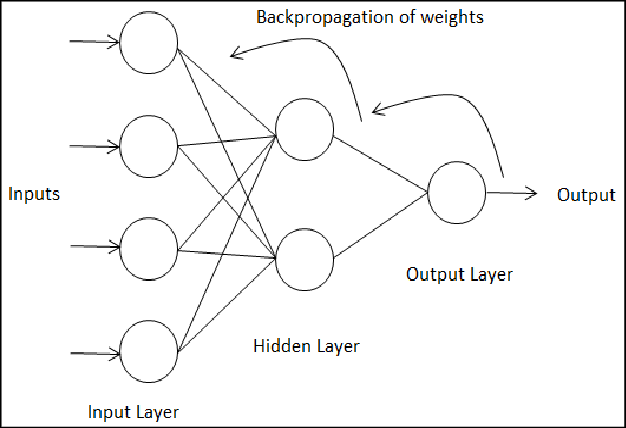



In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 11SpETIc56PReKuaUKEwWDvdkiynyyGFA
!unzip "/content/MNISTArchive.zip" -d "/content/"
!gzip -d "/content/t10k-labels-idx1-ubyte.gz"
!gzip -d "/content/t10k-images-idx3-ubyte.gz" 
!gzip -d "/content/train-labels-idx1-ubyte.gz"
!gzip -d "/content/train-images-idx3-ubyte.gz"

Downloading...
From: https://drive.google.com/uc?id=11SpETIc56PReKuaUKEwWDvdkiynyyGFA
To: /content/MNISTArchive.zip
100% 11.6M/11.6M [00:00<00:00, 56.3MB/s]
Archive:  /content/MNISTArchive.zip
  inflating: /content/t10k-labels-idx1-ubyte.gz  
  inflating: /content/__MACOSX/._t10k-labels-idx1-ubyte.gz  
  inflating: /content/t10k-images-idx3-ubyte.gz  
  inflating: /content/__MACOSX/._t10k-images-idx3-ubyte.gz  
  inflating: /content/train-labels-idx1-ubyte.gz  
  inflating: /content/__MACOSX/._train-labels-idx1-ubyte.gz  
  inflating: /content/train-images-idx3-ubyte.gz  
  inflating: /content/__MACOSX/._train-images-idx3-ubyte.gz  


## Helper Functions:

### Code

In [ ]:
def read_mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [ ]:
def initialize_network(sizes):

	network = dict()
 
	network['num_layers'] = len(sizes)
	network['bias'] = [np.random.randn(y, 1) for y in sizes[1:]]
	network['weights'] = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
	network['neurons'] = [np.zeros((y, 1)) for y in sizes[:]]
	
	return network

# Calculate neuron activation for an input
def pre_activation(weights, inputs,bias):
	inputs = inputs.reshape((len(inputs),1))
	return (weights @ inputs) + bias

def sigmoid_activation(activation):
	return 1.0/(1.0+np.exp(-activation))
 
# Calculate the derivative of a neuron output
def sigmoid_derivative(output):
	## write code. implement sigmoid function
	return (output)*(1-(output))
 
# Forward Propagation:
def forward_propagation(network,input):
	n_layers = network['num_layers']	
	network['neurons'][0] = input

	for i in range(0,n_layers-1):
		network['neurons'][i+1] = sigmoid_activation(pre_activation(network['weights'][i],network['neurons'][i],network['bias'][i]))
	
	return network

# get initial error
def getError(activation,ground_truth):
	return activation - ground_truth

# backward_prop error and find delta weights, delta biases
def backward_prop(network, ground_truth):

	n_layers = network['num_layers']
	delta_L = network['neurons'][-1] - ground_truth.reshape((len(ground_truth),1))
 
	deltas = [None] * (n_layers)
	deltas[-1] = delta_L
	dcost_dweight = [None] * (n_layers)
	for i in reversed(range(len(deltas))):
		if i>1:
			deltas_i = ((network['weights'][i-1].T) @ deltas[i]) * sigmoid_derivative(network['neurons'][i-1])
			deltas[i-1] = deltas_i
			dcost_dweight[i] = (deltas[i] @ network['neurons'][i-1].T)
	network['neurons'][0] = np.asarray(network['neurons'][0]).reshape((784,1))
	dcost_dweight[1] = (deltas[1] @ network['neurons'][0].T)

	deltas.pop(0)
	dcost_dweight.pop(0)
	dcost_dbias = deltas

	return dcost_dbias, dcost_dweight

def update_batch(network,l_rate,train_batch):

	n_b = [np.zeros(b.shape) for b in network['bias']]
	n_w = [np.zeros(w.shape) for w in network['weights']]
	expectedOutput = []
	groundTruths = []

	for x, y in train_batch:
			network = forward_propagation(network, x)
			expectedOutput.append(network['neurons'][-1])
			groundTruths.append(y)
			delta_n_b, delta_n_w = backward_prop(network, y)
			n_b = [nb+dnb for nb, dnb in zip(n_b, delta_n_b)]
			n_w = [nw+dnw for nw, dnw in zip(n_w, delta_n_w)]
	
	network['weights'] = [w-(l_rate/len(train_batch))*nw
									for w, nw in zip(network['weights'], n_w)]
	network['bias'] = [b-(l_rate/len(train_batch))*nb
									for b, nb in zip(network['bias'], n_b)]

	return network, expectedOutput, groundTruths

# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch):
	for epoch in range(n_epoch):

		sum_error = 0
		batch_size = 100

		n = len(train)
		random.shuffle(train)
	
		mini_batches = [ train[k:k+batch_size]	for k in range(0, n, batch_size)]

		for mini_batch in mini_batches:

			network, expectedOutput, gt = update_batch(network,l_rate,mini_batch)
			batch_error = 0

			for i in range(len(expectedOutput)):
				batch_error +=(np.asarray(expectedOutput[i]).reshape((10,1))-np.asarray(gt[i]).reshape((10,1)))
		
			batch_error = np.asarray(batch_error);
			batch_error = np.sum(batch_error**2)/(batch_size**2)
			sum_error+=batch_error

		sum_error = sum_error/(n/batch_size);
		print('>epoch=%d, lrate=%.3f, Training error=%.7f' % (epoch + 1, l_rate, sum_error))   
	return network

In [ ]:
# Read MNIST data and test above algorithm on it.

# Read MNIST data
train_images, train_labels, test_images, test_labels = read_mnist(path='/content/')

# Run Backpropagation.
train_set = []
for i in range(len(train_images)-10000):
  train_set.append([train_images[i],train_labels[i]])

network = initialize_network([784,500,50,10])

network = train_network(network, train_set, 0.5, 10)

>epoch=1, lrate=0.500, Training error=0.0093412
>epoch=2, lrate=0.500, Training error=0.0030113
>epoch=3, lrate=0.500, Training error=0.0021588
>epoch=4, lrate=0.500, Training error=0.0016784
>epoch=5, lrate=0.500, Training error=0.0014963
>epoch=6, lrate=0.500, Training error=0.0012953
>epoch=7, lrate=0.500, Training error=0.0011463
>epoch=8, lrate=0.500, Training error=0.0010572
>epoch=9, lrate=0.500, Training error=0.0009437
>epoch=10, lrate=0.500, Training error=0.0008333


In [ ]:
# Testing accuracy
len(test_images)
def getAccuracy(network, test_images, test_labels):
  total_pred = 0
  correct_pred = 0
  for i in range(len(test_images)):
    network = forward_propagation(network,train_images[i])

    if np.argmax(network['neurons'][-1]) == np.argmax(test_labels[i]):
      correct_pred += 1
    
    total_pred += 1
  
  accuracy = 100 * (correct_pred / total_pred)

  return accuracy

print('Training accuracy of the neural network on MNIST dataset at the end of training is ' + str(getAccuracy(network, train_images, train_labels)) + '\n')
print('Testing accuracy of the neural network on MNIST dataset at the end of training is ' + str(getAccuracy(network, test_images, test_labels)*0.8) + '\n')

Ablation study with different number of a) hidden layers b) training epochs

Smaller number of neurons in hidden layers are being used to cut down the training time.

Case 1 : 2 hidden layers of 50 neurons each, 5 epochs

In [ ]:
network1 = initialize_network([784,50,50,10])

network1 = train_network(network1, train_set, 0.5, 5)

>epoch=1, lrate=0.500, Training error=0.0153808
>epoch=2, lrate=0.500, Training error=0.0032590
>epoch=3, lrate=0.500, Training error=0.0023640
>epoch=4, lrate=0.500, Training error=0.0019528
>epoch=5, lrate=0.500, Training error=0.0017246


Case 2 : 2 hidden layers of 50 neurons each, 10 epochs

In [ ]:
network2 = initialize_network([784,50,50,10])

network2 = train_network(network2, train_set, 0.5, 10)

>epoch=1, lrate=0.500, Training error=0.0127388
>epoch=2, lrate=0.500, Training error=0.0032571
>epoch=3, lrate=0.500, Training error=0.0023835
>epoch=4, lrate=0.500, Training error=0.0020567
>epoch=5, lrate=0.500, Training error=0.0017074
>epoch=6, lrate=0.500, Training error=0.0015194
>epoch=7, lrate=0.500, Training error=0.0014106
>epoch=8, lrate=0.500, Training error=0.0013286
>epoch=9, lrate=0.500, Training error=0.0011918
>epoch=10, lrate=0.500, Training error=0.0011751


Case 3 : 4 hidden layers of 50 neurons each, 5 epochs

In [ ]:
network3 = initialize_network([784,50,50,50,50,10])

network3 = train_network(network3, train_set, 0.5, 5)

>epoch=1, lrate=0.500, Training error=0.0233151
>epoch=2, lrate=0.500, Training error=0.0044500
>epoch=3, lrate=0.500, Training error=0.0027959
>epoch=4, lrate=0.500, Training error=0.0022577
>epoch=5, lrate=0.500, Training error=0.0017905


Case 4 : 4 hidden layers of 50 neurons each, 10 epochs

In [ ]:
network4 = initialize_network([784,50,50,50,50,10])

network4 = train_network(network4, train_set, 0.5, 10)

>epoch=1, lrate=0.500, Training error=0.0250005
>epoch=2, lrate=0.500, Training error=0.0047283
>epoch=3, lrate=0.500, Training error=0.0029739
>epoch=4, lrate=0.500, Training error=0.0023553
>epoch=5, lrate=0.500, Training error=0.0018973
>epoch=6, lrate=0.500, Training error=0.0016037
>epoch=7, lrate=0.500, Training error=0.0014549
>epoch=8, lrate=0.500, Training error=0.0013459
>epoch=9, lrate=0.500, Training error=0.0011747


Beginning training errors are variable since everytime the weights in the network get randomly generated.

**General observations** : 

Smaller networks, with enough number of parameters as in Case 1 and Case 2 can learn the data efficiently and can quickly reduce the training error. However if the network is too small, the training error won't reduce since the model wouldn't have enough parameters to learn the data well.

Larger networks however start with a higher error in general, but given enough number of iterations, the training error can reduce more than the case of a shallower network (better learning). However, one has to be wary of using a very deep network without dropout and batchnormalizations, since the model can overfit on the data.